In [1]:
from matplotlib import pyplot as plt
import multigrate as mtg
import scanpy as sc

Global seed set to 0


# Load preprocessed data

We recommend using raw counts for scRNA-seq and TF-IDF normalized expression for ATAC-seq. You can also input binarized counts for ATAC, but normalized expression seems to integrate a bit better.

In [2]:
rna = sc.read('/storage/groups/ml01/workspace/anastasia.litinetskaya/multimil/10xpbmc10k-2020/10x_2020_rna_hvg.h5ad')
atac = sc.read('/storage/groups/ml01/workspace/anastasia.litinetskaya/multimil/10xpbmc10k-2020/10x_2020_atac.h5ad')

In [3]:
rna

AnnData object with n_obs × n_vars = 10000 × 4000
    obs: 'cell_type', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'cell_type_l2'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg'
    layers: 'count'

In [4]:
atac

AnnData object with n_obs × n_vars = 10000 × 40086
    obs: 'cell_type', 'cell_type_l2'
    layers: 'binary'

In [5]:
import numpy as np

In [6]:
np.max(rna.layers['count'])

844.0

In [7]:
np.max(atac.X)

2.6131697

# Prep the input AnnData object

First, we need to organize anndatas correspoding to different datasets and modalities into 1 anndata object. Here in this example we have 1 paired RNA-ATAC dataset, hence we input 2 anndata objects, 1 for rna modality, 1 for atac modality, and specify that they are paired (```groups``` argument).

Notes:
- paired datasets have to have the same .obs_names, i.e. index
- if there are batch effects in one dataset, please split the data into batches beforehand, becaues the model treats each input anndata object as 1 batch

If we had more unpaired data here, e.g. 1 paired RNA-ATAC dataset (```rna1```, ```atac1```) and 2 other RNA datasets (```rna2```, ```rna3```), we would have to first subset the RNA modality to the set of common genes (and then possibly to highly variable genes). Then we would need to specify
```adata = [[rna1, rna2, rna3], [atac]]``` and ```groups = [[0, 1, 2], [0]]```.

In [8]:
adata = mtg.data.organize_multiome_anndatas(
    adatas = [[rna], [atac]],     # a list of anndata objects per modality, RNA-seq always goes first
    groups = [[0], [0]],          # 
    layers = [['count'], [None]]  # if need to use data from .layers, if None use .X
)
adata

AnnData object with n_obs × n_vars = 10000 × 44086
    obs: 'cell_type', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'cell_type_l2', 'group'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    layers: 'count', 'binary'

Sanity check: in case of multiple datasets `len(adata)` should be equal `len(rna1) + len(rna2) + len(rna3)`.

From now on, we work with one concatenated anndata object ```adata```.

If using raw counts for scRNA, we need to use NB loss (or ZINB), thus need to calculate `size_factors` first. If using normalized counts and MSE for scRNA, `rna_indices_end` does not need to be specified.

In [9]:
mtg.model.MultiVAE.setup_anndata(
    adata,
    rna_indices_end=4000 # how many features in the rna-seq modality
)

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             


/home/icb/anastasia.litinetskaya/miniconda3/envs/multi/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


INFO     Successfully registered anndata object containing 10000 cells, 44086 vars, 1        
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 1 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


If categorical (e.g. sex) or continious covariates (e.g. age) are available, and you'd like to learn a latent representation disentangled from these covariates, additionally specify in setup_anndata
```
categorical_covariate_keys: ["sex"],
continuous_covariate_keys: ["age"]
```

# Initialize the model

Define the model here. If using raw counts for RNA-seq, use NB loss, if normalized counts, use MSE. If using normalized counts for ATAC-seq, use MSE, if binalized use BCE (`'bce'`).

In [10]:
model = mtg.model.MultiVAE(
    adata, 
    modality_lengths=[4000, 40086], # how many features per modality
    losses=['nb', 'mse'],           # what losses to use for each modality
    loss_coefs={'kl': 1e-2,
               'integ': 0},
    z_dim=15,
    cond_dim=10,
    dropout=0.2,
    n_layers_encoders=[2, 2],
)

/home/icb/anastasia.litinetskaya/miniconda3/envs/multi/lib/python3.8/site-packages/scvi/model/base/_base_model.py:150: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(


# Train the model

Can specify the number of epochs by setting `max_epochs` parameter, default is 500.

In [11]:
model.train(max_epochs=200)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 1/200:   0%|          | 1/200 [00:02<06:42,  2.02s/it, loss=1.13e+04, v_num=1]

Metric elbo_validation improved. New best score: 8916.110


Epoch 2/200:   1%|          | 2/200 [00:04<07:00,  2.13s/it, loss=8.83e+03, v_num=1]

Metric elbo_validation improved by 2044.203 >= min_delta = 0.0. New best score: 6871.908


Epoch 3/200:   2%|▏         | 3/200 [00:06<07:06,  2.17s/it, loss=7.76e+03, v_num=1]

Metric elbo_validation improved by 790.977 >= min_delta = 0.0. New best score: 6080.931


Epoch 4/200:   2%|▏         | 4/200 [00:08<07:16,  2.23s/it, loss=7.15e+03, v_num=1]

Metric elbo_validation improved by 324.496 >= min_delta = 0.0. New best score: 5756.435


Epoch 5/200:   2%|▎         | 5/200 [00:11<07:21,  2.26s/it, loss=6.81e+03, v_num=1]

Metric elbo_validation improved by 183.213 >= min_delta = 0.0. New best score: 5573.222


Epoch 6/200:   3%|▎         | 6/200 [00:13<07:20,  2.27s/it, loss=6.59e+03, v_num=1]

Metric elbo_validation improved by 92.998 >= min_delta = 0.0. New best score: 5480.224


Epoch 7/200:   4%|▎         | 7/200 [00:15<07:18,  2.27s/it, loss=6.39e+03, v_num=1]

Metric elbo_validation improved by 61.438 >= min_delta = 0.0. New best score: 5418.786


Epoch 8/200:   4%|▍         | 8/200 [00:17<07:17,  2.28s/it, loss=6.24e+03, v_num=1]

Metric elbo_validation improved by 37.069 >= min_delta = 0.0. New best score: 5381.716


Epoch 9/200:   4%|▍         | 9/200 [00:20<07:14,  2.27s/it, loss=6.13e+03, v_num=1]

Metric elbo_validation improved by 23.386 >= min_delta = 0.0. New best score: 5358.330


Epoch 10/200:   5%|▌         | 10/200 [00:22<07:19,  2.31s/it, loss=6.04e+03, v_num=1]

Metric elbo_validation improved by 17.361 >= min_delta = 0.0. New best score: 5340.969


Epoch 11/200:   6%|▌         | 11/200 [00:24<07:19,  2.32s/it, loss=6e+03, v_num=1]   

Metric elbo_validation improved by 13.385 >= min_delta = 0.0. New best score: 5327.584


Epoch 12/200:   6%|▌         | 12/200 [00:27<07:22,  2.35s/it, loss=5.89e+03, v_num=1]

Metric elbo_validation improved by 8.847 >= min_delta = 0.0. New best score: 5318.737


Epoch 13/200:   6%|▋         | 13/200 [00:29<07:21,  2.36s/it, loss=5.88e+03, v_num=1]

Metric elbo_validation improved by 7.885 >= min_delta = 0.0. New best score: 5310.852


Epoch 14/200:   7%|▋         | 14/200 [00:32<07:23,  2.39s/it, loss=5.82e+03, v_num=1]

Metric elbo_validation improved by 4.917 >= min_delta = 0.0. New best score: 5305.936


Epoch 15/200:   8%|▊         | 15/200 [00:34<07:19,  2.38s/it, loss=5.76e+03, v_num=1]

Metric elbo_validation improved by 5.746 >= min_delta = 0.0. New best score: 5300.189


Epoch 16/200:   8%|▊         | 16/200 [00:36<07:16,  2.37s/it, loss=5.78e+03, v_num=1]

Metric elbo_validation improved by 3.229 >= min_delta = 0.0. New best score: 5296.960


Epoch 17/200:   8%|▊         | 17/200 [00:39<07:14,  2.37s/it, loss=5.74e+03, v_num=1]

Metric elbo_validation improved by 3.361 >= min_delta = 0.0. New best score: 5293.599


Epoch 18/200:   9%|▉         | 18/200 [00:41<07:12,  2.38s/it, loss=5.68e+03, v_num=1]

Metric elbo_validation improved by 2.472 >= min_delta = 0.0. New best score: 5291.126


Epoch 19/200:  10%|▉         | 19/200 [00:44<07:08,  2.37s/it, loss=5.67e+03, v_num=1]

Metric elbo_validation improved by 1.803 >= min_delta = 0.0. New best score: 5289.323


Epoch 20/200:  10%|█         | 20/200 [00:46<07:05,  2.37s/it, loss=5.65e+03, v_num=1]

Metric elbo_validation improved by 1.469 >= min_delta = 0.0. New best score: 5287.854


Epoch 21/200:  10%|█         | 21/200 [00:48<07:00,  2.35s/it, loss=5.66e+03, v_num=1]

Metric elbo_validation improved by 1.059 >= min_delta = 0.0. New best score: 5286.796


Epoch 22/200:  11%|█         | 22/200 [00:50<06:55,  2.34s/it, loss=5.63e+03, v_num=1]

Metric elbo_validation improved by 1.313 >= min_delta = 0.0. New best score: 5285.482


Epoch 23/200:  12%|█▏        | 23/200 [00:53<06:51,  2.32s/it, loss=5.6e+03, v_num=1] 

Metric elbo_validation improved by 1.001 >= min_delta = 0.0. New best score: 5284.481


Epoch 24/200:  12%|█▏        | 24/200 [00:55<06:50,  2.33s/it, loss=5.58e+03, v_num=1]

Metric elbo_validation improved by 1.160 >= min_delta = 0.0. New best score: 5283.321


Epoch 25/200:  12%|█▎        | 25/200 [00:58<06:50,  2.34s/it, loss=5.58e+03, v_num=1]

Metric elbo_validation improved by 0.587 >= min_delta = 0.0. New best score: 5282.734


Epoch 26/200:  13%|█▎        | 26/200 [01:00<06:48,  2.35s/it, loss=5.56e+03, v_num=1]

Metric elbo_validation improved by 0.518 >= min_delta = 0.0. New best score: 5282.216


Epoch 27/200:  14%|█▎        | 27/200 [01:02<06:47,  2.35s/it, loss=5.51e+03, v_num=1]

Metric elbo_validation improved by 1.285 >= min_delta = 0.0. New best score: 5280.931


Epoch 28/200:  14%|█▍        | 28/200 [01:05<06:46,  2.36s/it, loss=5.53e+03, v_num=1]

Metric elbo_validation improved by 0.305 >= min_delta = 0.0. New best score: 5280.626


Epoch 29/200:  14%|█▍        | 29/200 [01:07<06:40,  2.34s/it, loss=5.5e+03, v_num=1] 

Metric elbo_validation improved by 0.496 >= min_delta = 0.0. New best score: 5280.130


Epoch 30/200:  15%|█▌        | 30/200 [01:09<06:32,  2.31s/it, loss=5.5e+03, v_num=1]

Metric elbo_validation improved by 0.813 >= min_delta = 0.0. New best score: 5279.317


Epoch 31/200:  16%|█▌        | 31/200 [01:11<06:27,  2.29s/it, loss=5.48e+03, v_num=1]

Metric elbo_validation improved by 0.687 >= min_delta = 0.0. New best score: 5278.630


Epoch 32/200:  16%|█▌        | 32/200 [01:14<06:24,  2.29s/it, loss=5.48e+03, v_num=1]

Metric elbo_validation improved by 0.879 >= min_delta = 0.0. New best score: 5277.751


Epoch 33/200:  16%|█▋        | 33/200 [01:16<06:20,  2.28s/it, loss=5.44e+03, v_num=1]

Metric elbo_validation improved by 0.410 >= min_delta = 0.0. New best score: 5277.341


Epoch 34/200:  16%|█▋        | 33/200 [01:16<06:20,  2.28s/it, loss=5.44e+03, v_num=1]

Metric elbo_validation improved by 1.269 >= min_delta = 0.0. New best score: 5276.072


Epoch 35/200:  18%|█▊        | 35/200 [01:20<06:12,  2.26s/it, loss=5.46e+03, v_num=1]

Metric elbo_validation improved by 2.076 >= min_delta = 0.0. New best score: 5273.997


Epoch 36/200:  18%|█▊        | 36/200 [01:23<06:09,  2.26s/it, loss=5.43e+03, v_num=1]

Metric elbo_validation improved by 3.722 >= min_delta = 0.0. New best score: 5270.275


Epoch 37/200:  18%|█▊        | 37/200 [01:25<06:07,  2.26s/it, loss=5.42e+03, v_num=1]

Metric elbo_validation improved by 5.199 >= min_delta = 0.0. New best score: 5265.076


Epoch 38/200:  19%|█▉        | 38/200 [01:27<06:05,  2.26s/it, loss=5.41e+03, v_num=1]

Metric elbo_validation improved by 9.087 >= min_delta = 0.0. New best score: 5255.988


Epoch 39/200:  20%|█▉        | 39/200 [01:29<06:04,  2.27s/it, loss=5.37e+03, v_num=1]

Metric elbo_validation improved by 15.234 >= min_delta = 0.0. New best score: 5240.754


Epoch 40/200:  20%|██        | 40/200 [01:32<06:01,  2.26s/it, loss=5.38e+03, v_num=1]

Metric elbo_validation improved by 25.903 >= min_delta = 0.0. New best score: 5214.852


Epoch 41/200:  20%|██        | 41/200 [01:34<05:58,  2.26s/it, loss=5.35e+03, v_num=1]

Metric elbo_validation improved by 28.177 >= min_delta = 0.0. New best score: 5186.674


Epoch 42/200:  21%|██        | 42/200 [01:36<05:56,  2.26s/it, loss=5.36e+03, v_num=1]

Metric elbo_validation improved by 18.434 >= min_delta = 0.0. New best score: 5168.241


Epoch 43/200:  22%|██▏       | 43/200 [01:38<05:51,  2.24s/it, loss=5.29e+03, v_num=1]

Metric elbo_validation improved by 15.183 >= min_delta = 0.0. New best score: 5153.058


Epoch 44/200:  22%|██▏       | 44/200 [01:41<05:51,  2.25s/it, loss=5.29e+03, v_num=1]

Metric elbo_validation improved by 16.626 >= min_delta = 0.0. New best score: 5136.431


Epoch 45/200:  22%|██▎       | 45/200 [01:43<05:50,  2.26s/it, loss=5.25e+03, v_num=1]

Metric elbo_validation improved by 17.659 >= min_delta = 0.0. New best score: 5118.772


Epoch 46/200:  23%|██▎       | 46/200 [01:45<05:46,  2.25s/it, loss=5.23e+03, v_num=1]

Metric elbo_validation improved by 18.162 >= min_delta = 0.0. New best score: 5100.610


Epoch 47/200:  24%|██▎       | 47/200 [01:47<05:44,  2.25s/it, loss=5.22e+03, v_num=1]

Metric elbo_validation improved by 17.082 >= min_delta = 0.0. New best score: 5083.528


Epoch 48/200:  24%|██▍       | 48/200 [01:50<05:40,  2.24s/it, loss=5.17e+03, v_num=1]

Metric elbo_validation improved by 15.565 >= min_delta = 0.0. New best score: 5067.963


Epoch 49/200:  24%|██▍       | 49/200 [01:52<05:38,  2.24s/it, loss=5.17e+03, v_num=1]

Metric elbo_validation improved by 7.776 >= min_delta = 0.0. New best score: 5060.187


Epoch 50/200:  25%|██▌       | 50/200 [01:54<05:35,  2.24s/it, loss=5.17e+03, v_num=1]

Metric elbo_validation improved by 6.163 >= min_delta = 0.0. New best score: 5054.023


Epoch 51/200:  26%|██▌       | 51/200 [01:56<05:33,  2.24s/it, loss=5.17e+03, v_num=1]

Metric elbo_validation improved by 4.093 >= min_delta = 0.0. New best score: 5049.930


Epoch 52/200:  26%|██▌       | 52/200 [01:59<05:32,  2.24s/it, loss=5.13e+03, v_num=1]

Metric elbo_validation improved by 3.292 >= min_delta = 0.0. New best score: 5046.638


Epoch 53/200:  26%|██▋       | 53/200 [02:01<05:31,  2.25s/it, loss=5.14e+03, v_num=1]

Metric elbo_validation improved by 2.978 >= min_delta = 0.0. New best score: 5043.660


Epoch 54/200:  27%|██▋       | 54/200 [02:03<05:28,  2.25s/it, loss=5.12e+03, v_num=1]

Metric elbo_validation improved by 1.637 >= min_delta = 0.0. New best score: 5042.023


Epoch 55/200:  28%|██▊       | 55/200 [02:05<05:27,  2.26s/it, loss=5.13e+03, v_num=1]

Metric elbo_validation improved by 1.512 >= min_delta = 0.0. New best score: 5040.511


Epoch 56/200:  28%|██▊       | 56/200 [02:08<05:26,  2.26s/it, loss=5.14e+03, v_num=1]

Metric elbo_validation improved by 2.323 >= min_delta = 0.0. New best score: 5038.188


Epoch 57/200:  28%|██▊       | 57/200 [02:10<05:24,  2.27s/it, loss=5.13e+03, v_num=1]

Metric elbo_validation improved by 1.134 >= min_delta = 0.0. New best score: 5037.053


Epoch 58/200:  29%|██▉       | 58/200 [02:12<05:21,  2.26s/it, loss=5.11e+03, v_num=1]

Metric elbo_validation improved by 2.063 >= min_delta = 0.0. New best score: 5034.990


Epoch 59/200:  30%|██▉       | 59/200 [02:15<05:19,  2.27s/it, loss=5.1e+03, v_num=1] 

Metric elbo_validation improved by 0.774 >= min_delta = 0.0. New best score: 5034.216


Epoch 60/200:  30%|███       | 60/200 [02:17<05:18,  2.28s/it, loss=5.1e+03, v_num=1]

Metric elbo_validation improved by 1.281 >= min_delta = 0.0. New best score: 5032.935


Epoch 61/200:  30%|███       | 61/200 [02:19<05:16,  2.28s/it, loss=5.08e+03, v_num=1]

Metric elbo_validation improved by 1.814 >= min_delta = 0.0. New best score: 5031.121


Epoch 62/200:  31%|███       | 62/200 [02:21<05:14,  2.28s/it, loss=5.08e+03, v_num=1]

Metric elbo_validation improved by 1.571 >= min_delta = 0.0. New best score: 5029.550


Epoch 63/200:  32%|███▏      | 63/200 [02:24<05:12,  2.28s/it, loss=5.1e+03, v_num=1] 

Metric elbo_validation improved by 1.942 >= min_delta = 0.0. New best score: 5027.608


Epoch 64/200:  32%|███▏      | 64/200 [02:26<05:10,  2.29s/it, loss=5.08e+03, v_num=1]

Metric elbo_validation improved by 1.532 >= min_delta = 0.0. New best score: 5026.076


Epoch 65/200:  32%|███▎      | 65/200 [02:28<05:06,  2.27s/it, loss=5.06e+03, v_num=1]

Metric elbo_validation improved by 1.837 >= min_delta = 0.0. New best score: 5024.239


Epoch 66/200:  33%|███▎      | 66/200 [02:30<05:03,  2.26s/it, loss=5.05e+03, v_num=1]

Metric elbo_validation improved by 1.379 >= min_delta = 0.0. New best score: 5022.859


Epoch 67/200:  34%|███▎      | 67/200 [02:33<04:59,  2.25s/it, loss=5.06e+03, v_num=1]

Metric elbo_validation improved by 1.602 >= min_delta = 0.0. New best score: 5021.257


Epoch 68/200:  34%|███▍      | 68/200 [02:35<04:55,  2.24s/it, loss=5.08e+03, v_num=1]

Metric elbo_validation improved by 1.327 >= min_delta = 0.0. New best score: 5019.931


Epoch 69/200:  34%|███▍      | 69/200 [02:37<04:55,  2.26s/it, loss=5.06e+03, v_num=1]

Metric elbo_validation improved by 2.755 >= min_delta = 0.0. New best score: 5017.176


Epoch 70/200:  35%|███▌      | 70/200 [02:39<04:53,  2.26s/it, loss=5.08e+03, v_num=1]

Metric elbo_validation improved by 1.316 >= min_delta = 0.0. New best score: 5015.860


Epoch 71/200:  36%|███▌      | 71/200 [02:42<04:50,  2.25s/it, loss=5.05e+03, v_num=1]

Metric elbo_validation improved by 2.144 >= min_delta = 0.0. New best score: 5013.716


Epoch 72/200:  36%|███▌      | 72/200 [02:44<04:49,  2.26s/it, loss=5.1e+03, v_num=1] 

Metric elbo_validation improved by 1.995 >= min_delta = 0.0. New best score: 5011.722


Epoch 73/200:  36%|███▋      | 73/200 [02:46<04:45,  2.25s/it, loss=5.04e+03, v_num=1]

Metric elbo_validation improved by 1.294 >= min_delta = 0.0. New best score: 5010.428


Epoch 74/200:  37%|███▋      | 74/200 [02:48<04:43,  2.25s/it, loss=5.06e+03, v_num=1]

Metric elbo_validation improved by 1.734 >= min_delta = 0.0. New best score: 5008.693


Epoch 75/200:  38%|███▊      | 75/200 [02:51<04:42,  2.26s/it, loss=5.05e+03, v_num=1]

Metric elbo_validation improved by 2.208 >= min_delta = 0.0. New best score: 5006.485


Epoch 76/200:  38%|███▊      | 76/200 [02:53<04:39,  2.26s/it, loss=5.05e+03, v_num=1]

Metric elbo_validation improved by 1.037 >= min_delta = 0.0. New best score: 5005.448


Epoch 77/200:  38%|███▊      | 77/200 [02:55<04:38,  2.26s/it, loss=5.07e+03, v_num=1]

Metric elbo_validation improved by 2.438 >= min_delta = 0.0. New best score: 5003.010


Epoch 78/200:  39%|███▉      | 78/200 [02:58<04:36,  2.27s/it, loss=5.08e+03, v_num=1]

Metric elbo_validation improved by 1.688 >= min_delta = 0.0. New best score: 5001.321


Epoch 79/200:  40%|███▉      | 79/200 [03:00<04:31,  2.24s/it, loss=5.04e+03, v_num=1]

Metric elbo_validation improved by 1.279 >= min_delta = 0.0. New best score: 5000.042


Epoch 80/200:  40%|████      | 80/200 [03:02<04:30,  2.25s/it, loss=5.05e+03, v_num=1]

Metric elbo_validation improved by 1.820 >= min_delta = 0.0. New best score: 4998.222


Epoch 81/200:  40%|████      | 81/200 [03:04<04:27,  2.25s/it, loss=5.03e+03, v_num=1]

Metric elbo_validation improved by 1.908 >= min_delta = 0.0. New best score: 4996.314


Epoch 82/200:  41%|████      | 82/200 [03:07<04:27,  2.27s/it, loss=5.03e+03, v_num=1]

Metric elbo_validation improved by 1.581 >= min_delta = 0.0. New best score: 4994.733


Epoch 83/200:  42%|████▏     | 83/200 [03:09<04:24,  2.26s/it, loss=5.03e+03, v_num=1]

Metric elbo_validation improved by 1.484 >= min_delta = 0.0. New best score: 4993.250


Epoch 84/200:  42%|████▏     | 84/200 [03:11<04:22,  2.26s/it, loss=5.01e+03, v_num=1]

Metric elbo_validation improved by 1.356 >= min_delta = 0.0. New best score: 4991.894


Epoch 85/200:  42%|████▎     | 85/200 [03:13<04:19,  2.26s/it, loss=5.03e+03, v_num=1]

Metric elbo_validation improved by 1.288 >= min_delta = 0.0. New best score: 4990.606


Epoch 86/200:  43%|████▎     | 86/200 [03:16<04:18,  2.27s/it, loss=5.04e+03, v_num=1]

Metric elbo_validation improved by 0.609 >= min_delta = 0.0. New best score: 4989.997


Epoch 87/200:  44%|████▎     | 87/200 [03:18<04:15,  2.26s/it, loss=5.01e+03, v_num=1]

Metric elbo_validation improved by 1.855 >= min_delta = 0.0. New best score: 4988.142


Epoch 88/200:  44%|████▍     | 88/200 [03:20<04:12,  2.25s/it, loss=5.02e+03, v_num=1]

Metric elbo_validation improved by 0.937 >= min_delta = 0.0. New best score: 4987.205


Epoch 89/200:  44%|████▍     | 89/200 [03:22<04:08,  2.24s/it, loss=5.04e+03, v_num=1]

Metric elbo_validation improved by 0.730 >= min_delta = 0.0. New best score: 4986.475


Epoch 90/200:  45%|████▌     | 90/200 [03:25<04:07,  2.25s/it, loss=5.03e+03, v_num=1]

Metric elbo_validation improved by 0.989 >= min_delta = 0.0. New best score: 4985.485


Epoch 91/200:  46%|████▌     | 91/200 [03:27<04:07,  2.27s/it, loss=5e+03, v_num=1]   

Metric elbo_validation improved by 1.684 >= min_delta = 0.0. New best score: 4983.802


Epoch 92/200:  46%|████▌     | 92/200 [03:29<04:04,  2.26s/it, loss=5.03e+03, v_num=1]

Metric elbo_validation improved by 0.578 >= min_delta = 0.0. New best score: 4983.224


Epoch 93/200:  46%|████▋     | 93/200 [03:31<04:00,  2.25s/it, loss=5.04e+03, v_num=1]

Metric elbo_validation improved by 1.260 >= min_delta = 0.0. New best score: 4981.964


Epoch 94/200:  47%|████▋     | 94/200 [03:34<04:05,  2.32s/it, loss=5.02e+03, v_num=1]

Metric elbo_validation improved by 1.021 >= min_delta = 0.0. New best score: 4980.943


Epoch 95/200:  48%|████▊     | 95/200 [03:36<04:01,  2.30s/it, loss=5.02e+03, v_num=1]

Metric elbo_validation improved by 1.069 >= min_delta = 0.0. New best score: 4979.874


Epoch 96/200:  48%|████▊     | 96/200 [03:38<03:56,  2.28s/it, loss=5.02e+03, v_num=1]

Metric elbo_validation improved by 0.609 >= min_delta = 0.0. New best score: 4979.265


Epoch 97/200:  48%|████▊     | 97/200 [03:41<03:54,  2.27s/it, loss=5.03e+03, v_num=1]

Metric elbo_validation improved by 1.537 >= min_delta = 0.0. New best score: 4977.728


Epoch 98/200:  49%|████▉     | 98/200 [03:43<03:51,  2.27s/it, loss=5.04e+03, v_num=1]

Metric elbo_validation improved by 0.894 >= min_delta = 0.0. New best score: 4976.833


Epoch 99/200:  50%|████▉     | 99/200 [03:45<03:49,  2.27s/it, loss=5.02e+03, v_num=1]

Metric elbo_validation improved by 1.131 >= min_delta = 0.0. New best score: 4975.702


Epoch 100/200:  50%|█████     | 100/200 [03:47<03:45,  2.26s/it, loss=5.02e+03, v_num=1]

Metric elbo_validation improved by 1.202 >= min_delta = 0.0. New best score: 4974.500


Epoch 101/200:  50%|█████     | 101/200 [03:50<03:43,  2.25s/it, loss=5.01e+03, v_num=1]

Metric elbo_validation improved by 1.665 >= min_delta = 0.0. New best score: 4972.835


Epoch 103/200:  52%|█████▏    | 103/200 [03:54<03:38,  2.25s/it, loss=5.02e+03, v_num=1]

Metric elbo_validation improved by 1.471 >= min_delta = 0.0. New best score: 4971.365


Epoch 104/200:  52%|█████▏    | 104/200 [03:56<03:36,  2.25s/it, loss=5.01e+03, v_num=1]

Metric elbo_validation improved by 1.199 >= min_delta = 0.0. New best score: 4970.166


Epoch 105/200:  52%|█████▎    | 105/200 [03:59<03:35,  2.27s/it, loss=5.01e+03, v_num=1]

Metric elbo_validation improved by 1.378 >= min_delta = 0.0. New best score: 4968.788


Epoch 106/200:  53%|█████▎    | 106/200 [04:01<03:33,  2.27s/it, loss=4.98e+03, v_num=1]

Metric elbo_validation improved by 1.213 >= min_delta = 0.0. New best score: 4967.575


Epoch 107/200:  54%|█████▎    | 107/200 [04:03<03:31,  2.28s/it, loss=4.99e+03, v_num=1]

Metric elbo_validation improved by 0.865 >= min_delta = 0.0. New best score: 4966.709


Epoch 108/200:  54%|█████▍    | 108/200 [04:05<03:29,  2.28s/it, loss=5.02e+03, v_num=1]

Metric elbo_validation improved by 0.839 >= min_delta = 0.0. New best score: 4965.871


Epoch 109/200:  55%|█████▍    | 109/200 [04:08<03:26,  2.27s/it, loss=5e+03, v_num=1]   

Metric elbo_validation improved by 0.754 >= min_delta = 0.0. New best score: 4965.117


Epoch 110/200:  55%|█████▌    | 110/200 [04:10<03:23,  2.26s/it, loss=5.03e+03, v_num=1]

Metric elbo_validation improved by 1.684 >= min_delta = 0.0. New best score: 4963.433


Epoch 111/200:  56%|█████▌    | 111/200 [04:12<03:21,  2.27s/it, loss=5.02e+03, v_num=1]

Metric elbo_validation improved by 1.612 >= min_delta = 0.0. New best score: 4961.820


Epoch 112/200:  56%|█████▌    | 112/200 [04:14<03:17,  2.25s/it, loss=5e+03, v_num=1]   

Metric elbo_validation improved by 1.513 >= min_delta = 0.0. New best score: 4960.308


Epoch 113/200:  56%|█████▋    | 113/200 [04:16<03:08,  2.17s/it, loss=5e+03, v_num=1]

Metric elbo_validation improved by 0.311 >= min_delta = 0.0. New best score: 4959.997


Epoch 114/200:  57%|█████▋    | 114/200 [04:18<03:04,  2.14s/it, loss=5.02e+03, v_num=1]

Metric elbo_validation improved by 1.396 >= min_delta = 0.0. New best score: 4958.602


Epoch 115/200:  57%|█████▊    | 115/200 [04:21<03:00,  2.13s/it, loss=5e+03, v_num=1]   

Metric elbo_validation improved by 1.974 >= min_delta = 0.0. New best score: 4956.627


Epoch 116/200:  58%|█████▊    | 116/200 [04:23<02:58,  2.12s/it, loss=5.01e+03, v_num=1]

Metric elbo_validation improved by 1.104 >= min_delta = 0.0. New best score: 4955.524


Epoch 117/200:  58%|█████▊    | 117/200 [04:25<02:51,  2.07s/it, loss=5e+03, v_num=1]   

Metric elbo_validation improved by 1.432 >= min_delta = 0.0. New best score: 4954.092


Epoch 118/200:  59%|█████▉    | 118/200 [04:27<02:48,  2.06s/it, loss=4.99e+03, v_num=1]

Metric elbo_validation improved by 1.488 >= min_delta = 0.0. New best score: 4952.604


Epoch 119/200:  60%|█████▉    | 119/200 [04:29<02:47,  2.07s/it, loss=5e+03, v_num=1]   

Metric elbo_validation improved by 1.040 >= min_delta = 0.0. New best score: 4951.564


Epoch 120/200:  60%|██████    | 120/200 [04:31<02:43,  2.05s/it, loss=5.03e+03, v_num=1]

Metric elbo_validation improved by 0.750 >= min_delta = 0.0. New best score: 4950.814


Epoch 121/200:  60%|██████    | 121/200 [04:33<02:41,  2.05s/it, loss=5.01e+03, v_num=1]

Metric elbo_validation improved by 1.408 >= min_delta = 0.0. New best score: 4949.406


Epoch 122/200:  61%|██████    | 122/200 [04:35<02:40,  2.06s/it, loss=4.97e+03, v_num=1]

Metric elbo_validation improved by 2.094 >= min_delta = 0.0. New best score: 4947.312


Epoch 123/200:  62%|██████▏   | 123/200 [04:37<02:39,  2.07s/it, loss=5e+03, v_num=1]   

Metric elbo_validation improved by 0.560 >= min_delta = 0.0. New best score: 4946.752


Epoch 124/200:  62%|██████▏   | 124/200 [04:39<02:37,  2.07s/it, loss=4.98e+03, v_num=1]

Metric elbo_validation improved by 0.744 >= min_delta = 0.0. New best score: 4946.008


Epoch 125/200:  62%|██████▎   | 125/200 [04:41<02:36,  2.09s/it, loss=4.98e+03, v_num=1]

Metric elbo_validation improved by 2.046 >= min_delta = 0.0. New best score: 4943.962


Epoch 126/200:  63%|██████▎   | 126/200 [04:43<02:32,  2.06s/it, loss=4.99e+03, v_num=1]

Metric elbo_validation improved by 0.177 >= min_delta = 0.0. New best score: 4943.785


Epoch 127/200:  64%|██████▎   | 127/200 [04:45<02:30,  2.06s/it, loss=4.98e+03, v_num=1]

Metric elbo_validation improved by 2.181 >= min_delta = 0.0. New best score: 4941.604


Epoch 128/200:  64%|██████▍   | 128/200 [04:47<02:28,  2.06s/it, loss=4.97e+03, v_num=1]

Metric elbo_validation improved by 1.694 >= min_delta = 0.0. New best score: 4939.910


Epoch 130/200:  65%|██████▌   | 130/200 [04:52<02:26,  2.09s/it, loss=4.97e+03, v_num=1]

Metric elbo_validation improved by 1.467 >= min_delta = 0.0. New best score: 4938.443


Epoch 132/200:  66%|██████▌   | 132/200 [04:56<02:19,  2.05s/it, loss=4.97e+03, v_num=1]

Metric elbo_validation improved by 1.012 >= min_delta = 0.0. New best score: 4937.431


Epoch 133/200:  66%|██████▋   | 133/200 [04:58<02:16,  2.03s/it, loss=4.98e+03, v_num=1]

Metric elbo_validation improved by 0.345 >= min_delta = 0.0. New best score: 4937.086


Epoch 134/200:  67%|██████▋   | 134/200 [05:00<02:15,  2.05s/it, loss=4.99e+03, v_num=1]

Metric elbo_validation improved by 1.945 >= min_delta = 0.0. New best score: 4935.141


Epoch 135/200:  68%|██████▊   | 135/200 [05:02<02:13,  2.05s/it, loss=4.98e+03, v_num=1]

Metric elbo_validation improved by 0.116 >= min_delta = 0.0. New best score: 4935.025


Epoch 137/200:  68%|██████▊   | 137/200 [05:06<02:07,  2.03s/it, loss=4.96e+03, v_num=1]

Metric elbo_validation improved by 0.365 >= min_delta = 0.0. New best score: 4934.660


Epoch 138/200:  69%|██████▉   | 138/200 [05:08<02:05,  2.03s/it, loss=4.95e+03, v_num=1]

Metric elbo_validation improved by 1.373 >= min_delta = 0.0. New best score: 4933.288


Epoch 139/200:  70%|██████▉   | 139/200 [05:10<02:03,  2.03s/it, loss=5.01e+03, v_num=1]

Metric elbo_validation improved by 1.731 >= min_delta = 0.0. New best score: 4931.556


Epoch 141/200:  70%|███████   | 141/200 [05:14<01:59,  2.03s/it, loss=4.97e+03, v_num=1]

Metric elbo_validation improved by 1.111 >= min_delta = 0.0. New best score: 4930.445


Epoch 142/200:  71%|███████   | 142/200 [05:16<01:59,  2.05s/it, loss=4.98e+03, v_num=1]

Metric elbo_validation improved by 0.262 >= min_delta = 0.0. New best score: 4930.184


Epoch 144/200:  72%|███████▏  | 144/200 [05:20<01:54,  2.05s/it, loss=4.95e+03, v_num=1]

Metric elbo_validation improved by 0.637 >= min_delta = 0.0. New best score: 4929.546


Epoch 146/200:  73%|███████▎  | 146/200 [05:24<01:49,  2.02s/it, loss=4.95e+03, v_num=1]

Metric elbo_validation improved by 1.132 >= min_delta = 0.0. New best score: 4928.415


Epoch 148/200:  74%|███████▍  | 148/200 [05:28<01:47,  2.06s/it, loss=4.96e+03, v_num=1]

Metric elbo_validation improved by 2.176 >= min_delta = 0.0. New best score: 4926.238


Epoch 151/200:  76%|███████▌  | 151/200 [05:35<01:41,  2.07s/it, loss=4.94e+03, v_num=1]

Metric elbo_validation improved by 0.273 >= min_delta = 0.0. New best score: 4925.965


Epoch 152/200:  76%|███████▌  | 152/200 [05:37<01:38,  2.06s/it, loss=4.95e+03, v_num=1]

Metric elbo_validation improved by 0.729 >= min_delta = 0.0. New best score: 4925.235


Epoch 154/200:  77%|███████▋  | 154/200 [05:41<01:35,  2.07s/it, loss=4.96e+03, v_num=1]

Metric elbo_validation improved by 1.190 >= min_delta = 0.0. New best score: 4924.045


Epoch 156/200:  78%|███████▊  | 156/200 [05:45<01:30,  2.07s/it, loss=4.94e+03, v_num=1]

Metric elbo_validation improved by 1.344 >= min_delta = 0.0. New best score: 4922.701


Epoch 159/200:  80%|███████▉  | 159/200 [05:51<01:25,  2.08s/it, loss=4.98e+03, v_num=1]

Metric elbo_validation improved by 0.023 >= min_delta = 0.0. New best score: 4922.678


Epoch 160/200:  80%|████████  | 160/200 [05:53<01:23,  2.10s/it, loss=4.97e+03, v_num=1]

Metric elbo_validation improved by 0.250 >= min_delta = 0.0. New best score: 4922.428


Epoch 161/200:  80%|████████  | 161/200 [05:55<01:21,  2.08s/it, loss=4.95e+03, v_num=1]

Metric elbo_validation improved by 0.764 >= min_delta = 0.0. New best score: 4921.664


Epoch 162/200:  81%|████████  | 162/200 [05:57<01:18,  2.07s/it, loss=4.95e+03, v_num=1]

Metric elbo_validation improved by 0.105 >= min_delta = 0.0. New best score: 4921.558


Epoch 163/200:  82%|████████▏ | 163/200 [05:59<01:15,  2.04s/it, loss=4.96e+03, v_num=1]

Metric elbo_validation improved by 0.448 >= min_delta = 0.0. New best score: 4921.110


Epoch 164/200:  82%|████████▏ | 164/200 [06:01<01:13,  2.04s/it, loss=4.95e+03, v_num=1]

Metric elbo_validation improved by 2.411 >= min_delta = 0.0. New best score: 4918.699


Epoch 169/200:  84%|████████▍ | 169/200 [06:12<01:03,  2.04s/it, loss=4.93e+03, v_num=1]

Metric elbo_validation improved by 0.147 >= min_delta = 0.0. New best score: 4918.552


Epoch 171/200:  86%|████████▌ | 171/200 [06:16<01:00,  2.08s/it, loss=4.94e+03, v_num=1]

Metric elbo_validation improved by 0.639 >= min_delta = 0.0. New best score: 4917.913


Epoch 172/200:  86%|████████▌ | 172/200 [06:18<00:58,  2.08s/it, loss=4.93e+03, v_num=1]

Metric elbo_validation improved by 1.112 >= min_delta = 0.0. New best score: 4916.801


Epoch 175/200:  88%|████████▊ | 175/200 [06:24<00:52,  2.10s/it, loss=4.93e+03, v_num=1]

Metric elbo_validation improved by 0.942 >= min_delta = 0.0. New best score: 4915.859


Epoch 181/200:  90%|█████████ | 181/200 [06:37<00:40,  2.15s/it, loss=4.94e+03, v_num=1]

Metric elbo_validation improved by 0.221 >= min_delta = 0.0. New best score: 4915.638


Epoch 182/200:  91%|█████████ | 182/200 [06:39<00:38,  2.15s/it, loss=4.95e+03, v_num=1]

Metric elbo_validation improved by 0.790 >= min_delta = 0.0. New best score: 4914.849


Epoch 184/200:  92%|█████████▏| 184/200 [06:44<00:34,  2.17s/it, loss=4.95e+03, v_num=1]

Metric elbo_validation improved by 0.726 >= min_delta = 0.0. New best score: 4914.123


Epoch 187/200:  94%|█████████▎| 187/200 [06:50<00:28,  2.16s/it, loss=4.93e+03, v_num=1]

Metric elbo_validation improved by 1.708 >= min_delta = 0.0. New best score: 4912.416


Epoch 190/200:  95%|█████████▌| 190/200 [06:57<00:21,  2.20s/it, loss=4.96e+03, v_num=1]

Metric elbo_validation improved by 0.290 >= min_delta = 0.0. New best score: 4912.126


Epoch 194/200:  97%|█████████▋| 194/200 [07:05<00:13,  2.18s/it, loss=4.93e+03, v_num=1]

Metric elbo_validation improved by 0.579 >= min_delta = 0.0. New best score: 4911.547


Epoch 196/200:  98%|█████████▊| 196/200 [07:09<00:08,  2.08s/it, loss=4.95e+03, v_num=1]

Metric elbo_validation improved by 0.257 >= min_delta = 0.0. New best score: 4911.290


Epoch 197/200:  98%|█████████▊| 197/200 [07:12<00:06,  2.09s/it, loss=4.96e+03, v_num=1]

Metric elbo_validation improved by 0.737 >= min_delta = 0.0. New best score: 4910.553


Epoch 199/200: 100%|█████████▉| 199/200 [07:16<00:02,  2.06s/it, loss=4.94e+03, v_num=1]

Metric elbo_validation improved by 0.055 >= min_delta = 0.0. New best score: 4910.498


Epoch 200/200: 100%|██████████| 200/200 [07:18<00:00,  2.19s/it, loss=4.95e+03, v_num=1]


Plot losses.

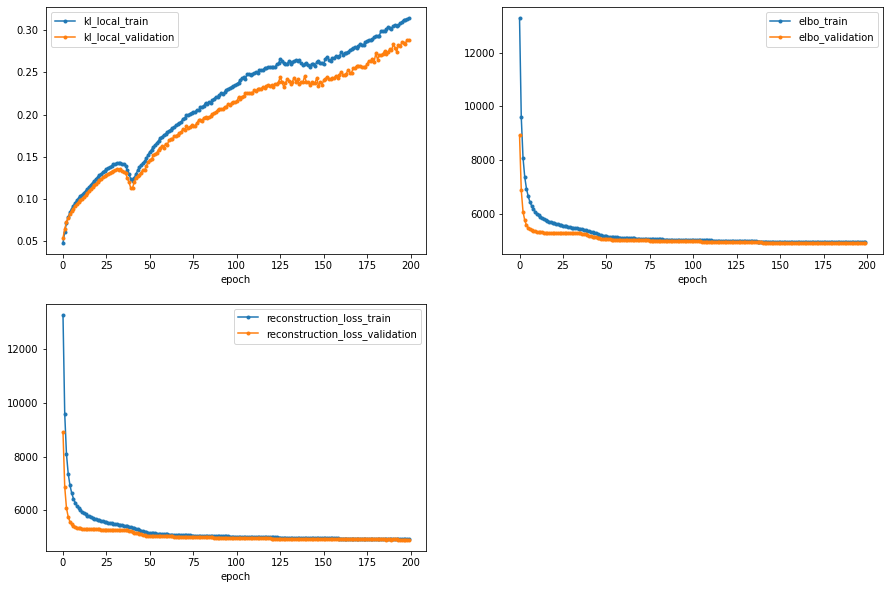

In [12]:
model.plot_losses()

# Inference

Get the latent representation.

In [13]:
model.get_latent_representation()
adata

/home/icb/anastasia.litinetskaya/miniconda3/envs/multi/lib/python3.8/site-packages/scvi/model/base/_base_model.py:150: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(


AnnData object with n_obs × n_vars = 10000 × 44086
    obs: 'cell_type', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'cell_type_l2', 'group', 'size_factors', '_scvi_batch', '_scvi_labels'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: '_scvi'
    obsm: '_scvi_extra_continuous', 'latent'
    layers: 'count', 'binary'

Visualize results.

... storing 'gene_ids' as categorical
... storing 'mt' as categorical
... storing 'highly_variable' as categorical


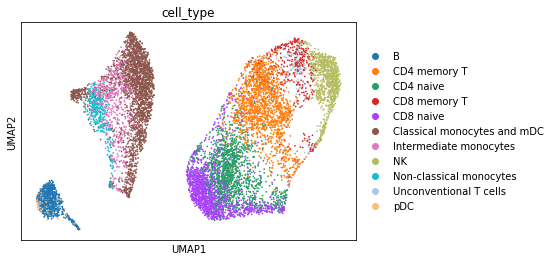

In [14]:
sc.pp.neighbors(adata, use_rep='latent')
sc.tl.umap(adata)
sc.pl.umap(adata, color='cell_type')

In [15]:
metrics = mtg.metrics.metrics(adata,
                batch_key=None,
                label_key='cell_type',
                embed='latent',
                isolated_labels_asw_=False,
                nmi_=True,
                ari_=True,
                silhouette_=True,
                graph_conn_=True,
                silhouette_batch_=False,
            )
metrics

NMI...
ARI...
Silhouette score...
Graph connectivity...


/home/icb/anastasia.litinetskaya/miniconda3/envs/multi/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


,0
NMI_cluster/label,0.765563
ARI_cluster/label,0.625420
ASW_label,0.560566
ASW_label/batch,NaN
isolated_label_silhouette,NaN
graph_conn,0.960730
